# Wealth Distribution Dynamics

# GPU

This lecture was built using a machine with JAX installed and access to a GPU.

To run this lecture on [Google Colab](https://colab.research.google.com/), click on the “play” icon top right, select Colab, and set the runtime environment to include a GPU.

To run this lecture on your own machine, you need to install [Google JAX](https://github.com/google/jax).

In this lecture we examine wealth dynamics in large cross-section of agents who
are subject to both

- idiosyncratic shocks, which affect labor income and returns, and  
- an aggregate shock, which also impacts on labor income and returns  


In most macroeconomic models savings and consumption are determined by optimization.

Here savings and consumption behavior is taken as given – you can plug in your
favorite model to obtain savings behavior and then analyze distribution dynamics
using the techniques described below.

One of our interests will be how different aspects of wealth dynamics – such
as labor income and the rate of return on investments – **feed into measures of
inequality**, such as the Gini coefficient.

In addition to JAX and Anaconda, this lecture will need the following libraries:

In [3]:
!pip install quantecon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.7/322.7 kB 6.8 MB/s eta 0:00:00


We will use the following imports:

In [4]:
import numba
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
import jax
import jax.numpy as jnp
from time import time

Let’s check the GPU we are running

In [5]:
!nvidia-smi

Mon Mar 31 10:34:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Wealth dynamics

Wealth evolves as follows:

$$
w_{t+1} = (1 + r_{t+1}) s(w_t) + y_{t+1}
$$

Here

- $ w_t $ is wealth at time $ t $ for a given household,  
- $ r_t $ is the rate of return of financial assets,  
- $ y_t $ is labor income and  
- $ s(w_t) $ is savings (current wealth minus current consumption)  


There is an aggregate state process

$$
z_{t+1} = a z_t + b + \sigma_z \epsilon_{t+1}
$$

that affects the interest rate and labor income.

- z_t:影响利率和劳动收入的宏观状态变量
- a：状态自回归系数，控制z_t 的持久性
- b：常数项，决定 zt的长期平均水平
- $ \sigma_z \epsilon_{t+1}$ ：随机冲击项，
$ \epsilon_{t+1}$为标准正态分布的独立同分布（IID）随机变量

这是AR1 process.



In particular, the gross interest rates obey

$$
R_t := 1 + r_t = c_r \exp(z_t) + \exp(\mu_r + \sigma_r \xi_t)
$$


while

$$
y_t = c_y \exp(z_t) + \exp(\mu_y + \sigma_y \zeta_t)
$$

The tuple $ \{ (\epsilon_t, \xi_t, \zeta_t) \} $ is IID and standard normal in $ \mathbb R^3 $.

(Each household receives their own idiosyncratic shocks.)



- $c_r \exp(z_t)$：由宏观状态 zt驱动的利率部分

- $\exp(\mu_r + \sigma_r \xi_t)$：包含随机冲击
$\xi_t$的 idiosyncratic 部分

- $\xi_t$：标准正态分布的独立同分布随机变量


Regarding the savings function $ s $, our default model will be


<a id='equation-sav-ah'></a>
$$
s(w) = s_0 w \cdot \mathbb 1\{w \geq \hat w\} \tag{7.1}
$$

where $ s_0 $ is a positive constant.

Thus,

- for $ w < \hat w $, the household saves nothing, while  
- for $ w \geq \bar w $, the household saves a fraction $ s_0 $ of their wealth.  

## Implementation

### Numba implementation

Here’s a function that collects parameters and useful constants

In [12]:
def create_wealth_model(w_hat=1.0,   # Savings parameter
                        s_0=0.75,    # Savings parameter
                        c_y=1.0,     # Labor income parameter
                        μ_y=1.0,     # Labor income parameter
                        σ_y=0.2,     # Labor income parameter
                        c_r=0.05,    # Rate of return parameter
                        μ_r=0.1,     # Rate of return parameter
                        σ_r=0.5,     # Rate of return parameter
                        a=0.5,       # Aggregate shock parameter
                        b=0.0,       # Aggregate shock parameter
                        σ_z=0.1):    # Aggregate shock parameter
    """
    Create a wealth model with given parameters.

    Return a tuple model = (household_params, aggregate_params), where
    household_params collects household information and aggregate_params
    collects information relevant to the aggregate shock process.

    """
    # Mean and variance of z process
    z_mean = b / (1 - a)
    z_var = σ_z**2 / (1 - a**2)
    exp_z_mean = np.exp(z_mean + z_var / 2)
    # Mean of R and y processes
    R_mean = c_r * exp_z_mean + np.exp(μ_r + σ_r**2 / 2)
    y_mean = c_y * exp_z_mean + np.exp(μ_y + σ_y**2 / 2)
    # Test stability condition ensuring wealth does not diverge
    # to infinity.
      # 为了防止财富无限增长，必须保证储蓄和利率的复合效应<1
    α = R_mean * s_0
    if α >= 1:
        raise ValueError("Stability condition failed.")
    # Pack values into tuples and return them
    household_params = (w_hat, s_0, c_y, μ_y, σ_y, c_r, μ_r, σ_r, y_mean)
    aggregate_params = (a, b, σ_z, z_mean, z_var)
    model = household_params, aggregate_params
    return model

Here’s a function that generates the aggregate state process

In [7]:
@numba.jit
def generate_aggregate_state_sequence(aggregate_params, length=100):
    a, b, σ_z, z_mean, z_var = aggregate_params
    z = np.empty(length+1) #创建一个大小为 length+1 的空数组（长度比 length 多 1，用于存储初始状态）
    z[0] = z_mean   # Initialize at z_mean
    for t in range(length):
        z[t+1] = a * z[t] + b + σ_z * np.random.randn()
    return z
    # 返回 z：长度为 length + 1 的序列，包含从 z0到zlength的宏观状态。

Here’s a function that updates household wealth by one period, taking the
current value of the aggregate shock

In [8]:
@numba.jit
def update_wealth(household_params, w, z):
    """
    Generate w_{t+1} given w_t and z_{t+1}.
    """
    # Unpack
    w_hat, s_0, c_y, μ_y, σ_y, c_r, μ_r, σ_r, y_mean = household_params
    # Update wealth
    y = c_y * np.exp(z) + np.exp(μ_y + σ_y * np.random.randn())
    wp = y
    if w >= w_hat:
        R = c_r * np.exp(z) + np.exp(μ_r + σ_r * np.random.randn())
        wp += R * s_0 * w
    return wp

Here’s a function to simulate the time series of wealth for an individual household

In [9]:
@numba.jit
def wealth_time_series(model, w_0, sim_length):
    """
    Generate a single time series of length sim_length for wealth given initial
    value w_0.  The function generates its own aggregate shock sequence.

    """
    # Unpack
    household_params, aggregate_params = model
    a, b, σ_z, z_mean, z_var = aggregate_params
    # Initialize and update
    z = generate_aggregate_state_sequence(aggregate_params,
                                          length=sim_length)
    w = np.empty(sim_length)
    w[0] = w_0
    for t in range(sim_length-1):
        w[t+1] = update_wealth(household_params, w[t], z[t+1])
    return w

Let’s look at the wealth dynamics of an individual household

In [10]:
model = create_wealth_model()
household_params, aggregate_params = model
w_hat, s_0, c_y, μ_y, σ_y, c_r, μ_r, σ_r, y_mean = household_params
a, b, σ_z, z_mean, z_var = aggregate_params
ts_length = 200
w = wealth_time_series(model, y_mean, ts_length)

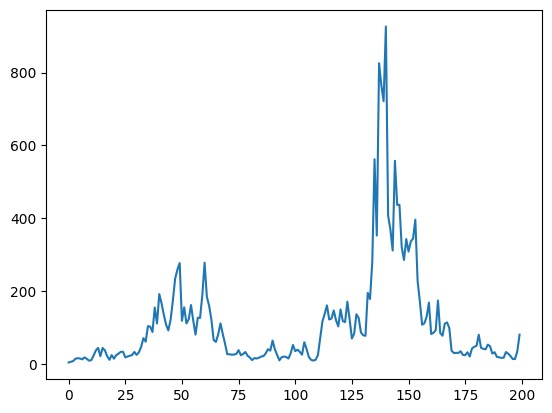

In [11]:
fig, ax = plt.subplots()
ax.plot(w)
plt.show()

Notice the large spikes in wealth over time.

Such spikes are related to heavy tails in the wealth distribution, which we
discuss below.

Here’s a function to simulate a cross section of households forward in time.

Note the use of parallelization to speed up computation.

In [13]:
@numba.jit(parallel=True)
def update_cross_section(model, w_distribution, z_sequence):
    """
    Shifts a cross-section of households forward in time（刚才是单个的，现在是distribution）

    Takes

        * a current distribution of wealth values as w_distribution and
        * an aggregate shock sequence z_sequence

    and updates each w_t in w_distribution to w_{t+j}, where
    j = len(z_sequence).

    Returns the new distribution.

    """
    # Unpack
    household_params, aggregate_params = model

    num_households = len(w_distribution)
    new_distribution = np.empty_like(w_distribution)
    z = z_sequence

    # Update each household
    for i in numba.prange(num_households):
        w = w_distribution[i]
        for t in range(sim_length):
            w = update_wealth(household_params, w, z[t])
        new_distribution[i] = w
    return new_distribution

Parallelization works in the function above because the time path of each
household can be calculated independently once the path for the aggregate state
is known.

Let’s see how long it takes to shift a large cross-section of households forward
200 periods

In [14]:
sim_length = 200
num_households = 10_000_000
ψ_0 = np.full(num_households, y_mean)  # Initial distribution
z_sequence = generate_aggregate_state_sequence(aggregate_params,
                                               length=sim_length)
print("Generating cross-section using Numba")
start = time()
ψ_star = update_cross_section(model, ψ_0, z_sequence)
numba_with_compile = time() - start
print(f"Generated cross-section in {numba_with_compile} seconds.\n")

Generating cross-section using Numba
Generated cross-section in 195.59301352500916 seconds.



We run it again to eliminate compile time.

In [16]:
start = time()
ψ_star = update_cross_section(model, ψ_0, z_sequence)
numba_without_compile = time() - start
print(f"Generated cross-section in {numba_without_compile} seconds.\n")

Generated cross-section in 199.288188457489 seconds.



### JAX implementation

Let’s redo some of the preceding calculations using JAX and see how execution
speed compares

In [15]:
def update_cross_section_jax(model, w_distribution, z_sequence, key):
    """
    Shifts a cross-section of households forward in time

    Takes

        * a current distribution of wealth values as w_distribution and
        * an aggregate shock sequence z_sequence

    and updates each w_t in w_distribution to w_{t+j}, where
    j = len(z_sequence).

    Returns the new distribution.

    """
    # Unpack, simplify names
    household_params, aggregate_params = model
    w_hat, s_0, c_y, μ_y, σ_y, c_r, μ_r, σ_r, y_mean = household_params
    w = w_distribution
    n = len(w)

    # Update wealth
    # 批量更新： w 在每个时间点被矢量化更新，无需逐个家庭循环。
    for t, z in enumerate(z_sequence):
        U = jax.random.normal(key, (2, n))
        y = c_y * jnp.exp(z) + jnp.exp(μ_y + σ_y * U[0, :])
        R = c_r * jnp.exp(z) + jnp.exp(μ_r + σ_r * U[1, :])
        w = y + jnp.where(w < w_hat, 0.0, R * s_0 * w)
        key, subkey = jax.random.split(key)

    return w

Let’s see how long it takes to shift the cross-section of households forward
using JAX

In [17]:
sim_length = 200
num_households = 10_000_000
ψ_0 = jnp.full(num_households, y_mean)  # Initial distribution
z_sequence = generate_aggregate_state_sequence(aggregate_params,
                                               length=sim_length)
z_sequence = jnp.array(z_sequence)

In [18]:
print("Generating cross-section using JAX")
key = jax.random.PRNGKey(1234)
start = time()
ψ_star = update_cross_section_jax(model, ψ_0, z_sequence, key).block_until_ready()
jax_with_compile = time() - start
print(f"Generated cross-section in {jax_with_compile} seconds.\n")

Generating cross-section using JAX
Generated cross-section in 3.242628574371338 seconds.



In [19]:
print("Repeating without compile time.")
key = jax.random.PRNGKey(1234)
start = time()
ψ_star = update_cross_section_jax(model, ψ_0, z_sequence, key).block_until_ready()
jax_without_compile = time() - start
print(f"Generated cross-section in {jax_without_compile} seconds")

Repeating without compile time.
Generated cross-section in 1.3332555294036865 seconds


And let’s see how long it takes if we compile the loop.

In [20]:
def update_cross_section_jax_compiled(model,
                                      w_distribution,
                                      w_size,
                                      z_sequence,
                                      key):
    """
    Shifts a cross-section of households forward in time

    Takes

        * a current distribution of wealth values as w_distribution and
        * an aggregate shock sequence z_sequence

    and updates each w_t in w_distribution to w_{t+j}, where
    j = len(z_sequence).

    Returns the new distribution.

    """
    # Unpack, simplify names
    household_params, aggregate_params = model
    w_hat, s_0, c_y, μ_y, σ_y, c_r, μ_r, σ_r, y_mean = household_params
    w = w_distribution
    n = len(w)
    z = z_sequence
    sim_length = len(z)

    def body_function(t, state):
        key, w = state
        key, subkey = jax.random.split(key)
        U = jax.random.normal(subkey, (2, n))
        y = c_y * jnp.exp(z[t]) + jnp.exp(μ_y + σ_y * U[0, :])
        R = c_r * jnp.exp(z[t]) + jnp.exp(μ_r + σ_r * U[1, :])
        w = y + jnp.where(w < w_hat, 0.0, R * s_0 * w)
        return key, w

    key, w = jax.lax.fori_loop(0, sim_length, body_function, (key, w))
    return w

    # fori_loop 是 JAX 提供的 高效循环控制函数，相当于 标准的 Python for 循环 的 JAX 版本。

In [21]:
update_cross_section_jax_compiled = jax.jit(
        update_cross_section_jax_compiled, static_argnums=(2,)
)

In [22]:
print("Generating cross-section using JAX with compiled loop")
key = jax.random.PRNGKey(1234)
start = time()
ψ_star = update_cross_section_jax_compiled(
        model, ψ_0, num_households, z_sequence, key
).block_until_ready()
jax_fori_with_compile = time() - start
print(f"Generated cross-section in {jax_fori_with_compile} seconds.\n")

Generating cross-section using JAX with compiled loop
Generated cross-section in 1.028059720993042 seconds.



In [23]:
print("Repeating without compile time")
key = jax.random.PRNGKey(1234)
start = time()
ψ_star = update_cross_section_jax_compiled(
        model, ψ_0, num_households, z_sequence, key
).block_until_ready()
jax_fori_without_compile = time() - start
print(f"Generated cross-section in {jax_fori_without_compile} seconds")

Repeating without compile time
Generated cross-section in 0.2552485466003418 seconds


In [24]:
print(f"JAX is {numba_without_compile/jax_fori_without_compile:.4f} times faster.\n")

JAX is 780.7613 times faster.



### Pareto tails

In most countries, the cross-sectional distribution of wealth exhibits a Pareto
tail (power law).

Let’s see if our model can replicate this stylized fact by running a simulation
that generates a cross-section of wealth and generating a suitable rank-size plot.

We will use the function `rank_size` from `quantecon` library.

In the limit, data that obeys a power law generates a straight line.

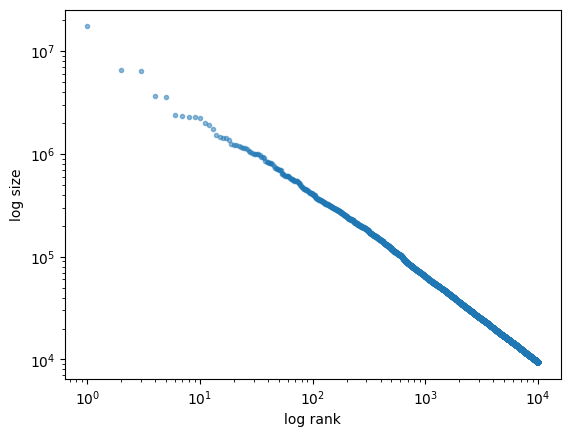

In [25]:
model = create_wealth_model()
key = jax.random.PRNGKey(1234)
ψ_star = update_cross_section_jax_compiled(
        model, ψ_0, num_households, z_sequence, key
)
fig, ax = plt.subplots()

rank_data, size_data = qe.rank_size(ψ_star, c=0.001)
ax.loglog(rank_data, size_data, 'o', markersize=3.0, alpha=0.5)
ax.set_xlabel("log rank")
ax.set_ylabel("log size")

plt.show()

### Lorenz curves and Gini coefficients

To study the impact of parameters on inequality, we examine Lorenz curves
and the Gini coefficients at different parameters.

QuantEcon provides functions to compute Lorenz curves and Gini coefficients that are accelerated using Numba.

Here we provide JAX-based functions that do the same job and are faster for large data sets on parallel hardware.

#### Lorenz curve

Recall that, for sorted data $ w_1, \ldots, w_n $, the Lorenz curve
generates data points $ (x_i, y_i)_{i=0}^n $  according to

$$
x_0 = y_0 = 0
    \qquad \text{and, for } i \geq 1, \quad
    x_i = \frac{i}{n},
    \qquad
    y_i =
       \frac{\sum_{j \leq i} w_j}{\sum_{j \leq n} w_j}
$$

- xi表示前
i 个家庭（或个体）在总人口中的比例。
- yi表示前
i 个家庭所拥有的财富或收入占总财富或收入的比例。



In [26]:
# w：一个长度为 n 的 财富或收入数组。

# w_size：静态参数，通常是 数据的大小信息，但在实际函数中 没有直接使用。



def _lorenz_curve_jax(w, w_size):
    n = w.shape[0] # w的长度
    w = jnp.sort(w)
    x = jnp.arange(n + 1) / n # jnp.arange(n + 1) 生成从 0 到n 的整数数组
    s = jnp.concatenate((jnp.zeros(1), jnp.cumsum(w)))
      # jnp.concatenate()： 将多个数组 拼接 在一起，形成一个新的数组。
      # jnp.zeros(1)： 生成一个长度为 1 的 零数组。
      # jnp.cumsum()： 计算数组 w 的 累积和。
    y = s / s[n]
      # si/s(总和)，也就是s的最后一个
    return x, y
      # 返回 x 和 y，表示 人口累计比例 和 财富或收入的累计比例。

lorenz_curve_jax = jax.jit(_lorenz_curve_jax, static_argnums=(1,))

# static_argnums=(1,)：w_size 是一个 静态参数，在编译时不会改变。
# 将 w_size 设为静态参数可以 优化计算速度，因为 JAX 会提前编译并缓存函数。



Let’s test

In [27]:
sim_length = 200
num_households = 1_000_000
ψ_0 = jnp.full(num_households, y_mean)  # Initial distribution
z_sequence = generate_aggregate_state_sequence(aggregate_params,
                                               length=sim_length)
z_sequence = jnp.array(z_sequence)

In [28]:
key = jax.random.PRNGKey(1234)
ψ_star = update_cross_section_jax_compiled(
        model, ψ_0, num_households, z_sequence, key
)

In [29]:
%time _ = lorenz_curve_jax(ψ_star, num_households)

CPU times: user 231 ms, sys: 7.96 ms, total: 239 ms
Wall time: 329 ms


In [30]:
# Now time it without compile time
%time x, y = lorenz_curve_jax(ψ_star, num_households)

CPU times: user 307 µs, sys: 997 µs, total: 1.3 ms
Wall time: 783 µs


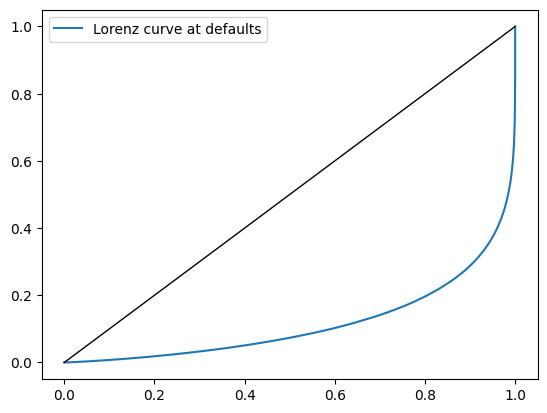

In [31]:
fig, ax = plt.subplots()
ax.plot(x, y, label="Lorenz curve at defaults")
ax.plot(x, x, 'k-', lw=1)
ax.legend()
plt.show()

#### Gini Coefficient

Recall that, for sorted data $ w_1, \ldots, w_n $, the Gini coefficient takes the form


<a id='equation-eq-gini'></a>
$$
G :=
\frac
    {\sum_{i=1}^n \sum_{j = 1}^n |w_j - w_i|}
    {2n\sum_{i=1}^n w_i}. \tag{7.2}
$$

Here’s a function that computes the Gini coefficient using vectorization.

In [32]:
def _gini_jax(w, w_size):
    w_1 = jnp.reshape(w, (w_size, 1)) # w_1：将 w 变成一个 列向量，形状为(w_size, 1)
    w_2 = jnp.reshape(w, (1, w_size))
    g_sum = jnp.sum(jnp.abs(w_1 - w_2)) # jnp.abs(w_1 - w_2) 生成一个 (w_size, w_size)的矩阵，其中每个元素是 abs(w_1 - w_2)
    return g_sum / (2 * w_size * jnp.sum(w))

gini_jax = jax.jit(_gini_jax, static_argnums=(1,))
# static_argnums=(1,) 指定 w_size 为 静态参数：

In [33]:
%time gini = gini_jax(ψ_star, num_households).block_until_ready()

CPU times: user 151 ms, sys: 7.94 ms, total: 159 ms
Wall time: 7.84 s


In [34]:
# Now time it without compilation
%time gini = gini_jax(ψ_star, num_households).block_until_ready()

CPU times: user 21.2 ms, sys: 4.95 ms, total: 26.1 ms
Wall time: 7.64 s


In [35]:
gini

Array(0.7683847, dtype=float32)

## Exercises

## Exercise 7.1

In this exercise, write an alternative version of `gini_jax` that uses `vmap` instead of reshaping and broadcasting.

Test with the same array to see if you can obtain the same output

## Solution to[ Exercise 7.1](https://jax.quantecon.org/#wd_ex1)

Here’s one solution:

In [ ]:
@jax.jit
def gini_jax_vmap(w):

    def _inner_sum(x):
        return jnp.sum(jnp.abs(x - w))

    inner_sum = jax.vmap(_inner_sum)

    full_sum = jnp.sum(inner_sum(w))
    return full_sum / (2 * len(w) * jnp.sum(w))

In [ ]:
%time gini = gini_jax_vmap(ψ_star).block_until_ready()

In [ ]:
# Now time it without compile time
%time gini = gini_jax_vmap(ψ_star).block_until_ready()

In [ ]:
gini

jax.vmap 是 JAX 提供的 矢量化映射函数，用于将一个标量操作应用到数组的每个元素上。


等价于在 for 循环中对数组的每个元素执行相同的函数，但 效率更高。

jax.vmap(fun, in_axes=0, out_axes=0)

- fun：要进行映射的函数。

- in_axes：指定输入数据的轴。

- out_axes：指定输出数据的轴。

vmap ： 将一个函数 矢量化，并应用到输入数组的每个元素。

等价于：
```python
results = []
for x in w:
    results.append(_inner_sum(x))
```

### ✅ **6. `vmap` 的深度解析**

---

#### 📌 **(1) `vmap` 的矩阵化原理**

- `jax.vmap` 的基本思想是 **矩阵广播**。  
- `vmap` 的 **矢量化映射** 通过 **将标量函数 `fun` 应用于数组的每个元素** 来实现：  

$$
\text{vmap}(f)(x) = \begin{pmatrix}
f(x_1) \\
f(x_2) \\
\vdots \\
f(x_n)
\end{pmatrix}
$$

---

#### 📌 **(2) `vmap` 的具体工作方式**

- 通过 `vmap` 映射 `_inner_sum(x)` 到 `w` 的每个元素：  

```python
inner_sum = jax.vmap(_inner_sum)
result = inner_sum(w)
```

`inner_sum(w)` 等效于：

$$
\text{inner\_sum}(w) = \begin{pmatrix}
\sum_{j=1}^{n} |w_1 - w_j| \\
\sum_{j=1}^{n} |w_2 - w_j| \\
\vdots \\
\sum_{j=1}^{n} |w_n - w_j|
\end{pmatrix}
$$



- `inner_sum(w)` 计算了 **`w` 中每个元素** 与 `w` 中 **所有元素** 之间的绝对差之和。
- 结果是一个长度为 `n` 的 **向量**，每个元素对应一个 `w_i` 的累积差距。

## Exercise 7.2

In this exercise we investigate how the parameters determining the rate of return on assets and labor income shape inequality.

In doing so we recall that

$$
R_t := 1 + r_t = c_r \exp(z_t) + \exp(\mu_r + \sigma_r \xi_t)
$$

while

$$
y_t = c_y \exp(z_t) + \exp(\mu_y + \sigma_y \zeta_t)
$$

Investigate how the Lorenz curves and the Gini coefficient associated with the wealth distribution change as **return to savings varies**.

In particular, plot Lorenz curves for the following three different values of $ \mu_r $

In [36]:
μ_r_vals = (0.0, 0.025, 0.05)

Use the following as your initial cross-sectional distribution

In [37]:
num_households = 1_000_000
ψ_0 = jnp.full(num_households, y_mean)  # Initial distribution

Once you have done that, plot the Gini coefficients as well.

Do the outcomes match your intuition?

## Solution to[ Exercise 7.2](https://jax.quantecon.org/#wd_ex2)

Here is one solution

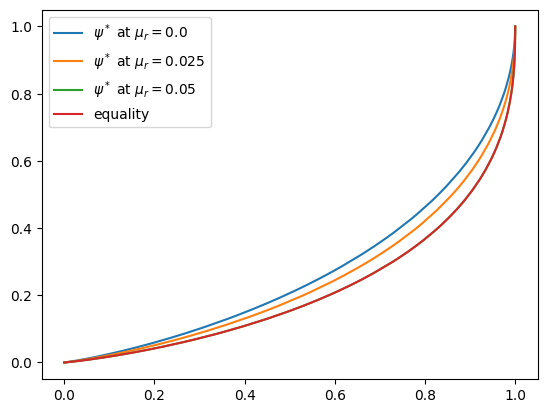

In [38]:
key = jax.random.PRNGKey(1234)
fig, ax = plt.subplots()
gini_vals = []
for μ_r in μ_r_vals:
    model = create_wealth_model(μ_r=μ_r)
    ψ_star = update_cross_section_jax_compiled(
            model, ψ_0, num_households, z_sequence, key
    )
    x, y = lorenz_curve_jax(ψ_star, num_households)
    g = gini_jax(ψ_star, num_households)
    ax.plot(x, y, label=f'$\psi^*$ at $\mu_r = {μ_r:0.2}$')
    gini_vals.append(g)
ax.plot(x, y, label='equality')
ax.legend(loc="upper left")
plt.show()

The Lorenz curve shifts downwards as returns on financial income rise, indicating a rise in inequality.

Now let’s check the Gini coefficient

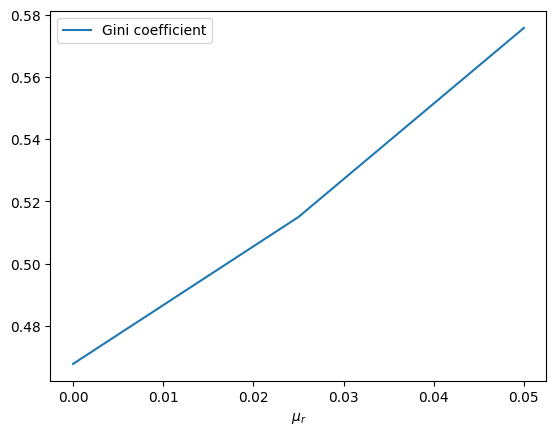

In [39]:
fig, ax = plt.subplots()
ax.plot(μ_r_vals, gini_vals, label='Gini coefficient')
ax.set_xlabel("$\mu_r$")
ax.legend()
plt.show()

As expected, inequality increases as returns on financial income rise.

## Exercise 7.3

Now investigate what happens when we change the volatility term $ \sigma_r $ in financial returns.

Use the same initial condition as before and the sequence

In [40]:
σ_r_vals = (0.35, 0.45, 0.52)

To isolate the role of volatility, set $ \mu_r = - \sigma_r^2 / 2 $ at each $ \sigma_r $.

(This holds the variance of the idiosyncratic term $ \exp(\mu_r + \sigma_r \zeta) $ constant.)

## Solution to[ Exercise 7.3](https://jax.quantecon.org/#wd_ex3)

Here’s one solution

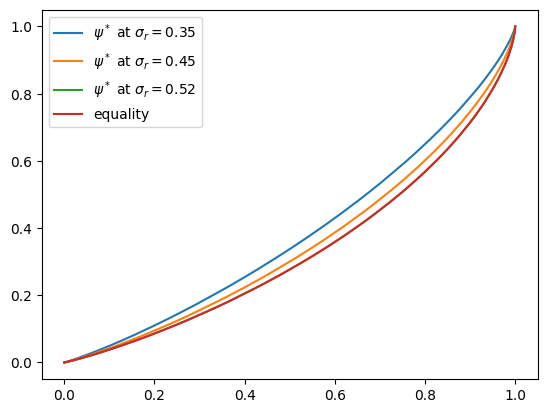

In [41]:
key = jax.random.PRNGKey(1234)
fig, ax = plt.subplots()

gini_vals = []
for σ_r in σ_r_vals:
    model = create_wealth_model(σ_r=σ_r, μ_r=(-σ_r**2/2))
    ψ_star = update_cross_section_jax_compiled(
            model, ψ_0, num_households, z_sequence, key
    )
    x, y = lorenz_curve_jax(ψ_star, num_households)
    g = gini_jax(ψ_star, num_households)
    ax.plot(x, y, label=f'$\psi^*$ at $\sigma_r = {σ_r:0.2}$')
    gini_vals.append(g)
ax.plot(x, y, label='equality')
ax.legend(loc="upper left")
plt.show()

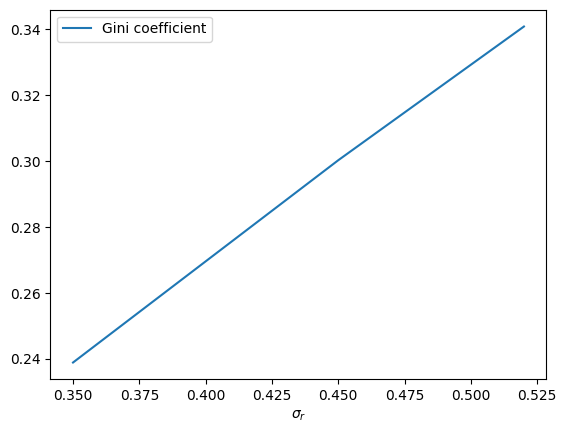

In [42]:
fig, ax = plt.subplots()
ax.plot(σ_r_vals, gini_vals, label='Gini coefficient')
ax.set_xlabel("$\sigma_r$")
ax.legend()
plt.show()

## Exercise 7.4

In this exercise, examine which has more impact on inequality:

- a 5% rise in volatility of the rate of return,  
- or a 5% rise in volatility of labor income.  


Test this by

1. Shifting $ \sigma_r $ up 5% from the baseline and plotting the Lorenz curve  
1. Shifting $ \sigma_y $ up 5% from the baseline and plotting the Lorenz curve  


Plot both on the same figure and examine the result.

## Solution to[ Exercise 7.4](https://jax.quantecon.org/#wd_ex4)

Here’s one solution.

It shows that increasing volatility in financial income has a greater effect

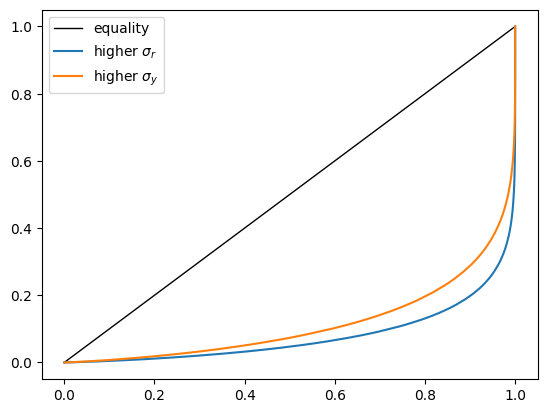

In [43]:
model = create_wealth_model()
household_params, aggregate_params = model
w_hat, s_0, c_y, μ_y, σ_y, c_r, μ_r, σ_r, y_mean = household_params
σ_r_default = σ_r
σ_y_default = σ_y

ψ_star = update_cross_section_jax_compiled(
            model, ψ_0, num_households, z_sequence, key
)
x_default, y_default = lorenz_curve_jax(ψ_star, num_households)

model = create_wealth_model(σ_r=(1.05 * σ_r_default))
ψ_star = update_cross_section_jax_compiled(
            model, ψ_0, num_households, z_sequence, key
)
x_financial, y_financial = lorenz_curve_jax(ψ_star, num_households)

model = create_wealth_model(σ_y=(1.05 * σ_y_default))
ψ_star = update_cross_section_jax_compiled(
            model, ψ_0, num_households, z_sequence, key
)
x_labor, y_labor = lorenz_curve_jax(ψ_star, num_households)

fig, ax = plt.subplots()
ax.plot(x_default, x_default, 'k-', lw=1, label='equality')
ax.plot(x_financial, y_financial, label=r'higher $\sigma_r$')
ax.plot(x_labor, y_labor, label=r'higher $\sigma_y$')
ax.legend()
plt.show()